In [16]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Embedding, LSTM
import seaborn as sns

In [2]:
training_drop_na_df = pd.read_csv(r"C:\Users\jjtre\Documents\UCSD Coding Bootcamp Data Science\Final Project\testing_cleaned_tweets_stopword_filter_dropnan.csv", encoding='utf-8')
training_drop_na_df.head()

,tweet_polarity,tweet_text,clean_tweets
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww bummer shoulda got david carr third day
1,0,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...
2,0,@Kenichan I dived many times for the ball. Man...,dived many times ball managed save 50 rest go ...
3,0,my whole body feels itchy and like its on fire,whole body feels itchy like fire
4,0,"@nationwideclass no, it's not behaving at all....",behaving mad see


In [3]:
training_drop_na_df['tweet_polarity'].value_counts()

4    796299
0    796229
Name: tweet_polarity, dtype: int64

In [4]:
# make a smaller cut of dataframe to test... way to long to run the whole model
# try 25K neg and pos
neg_df = training_drop_na_df.iloc[0:25000] # first 25K rows of dataframe
neg_df.head()

,tweet_polarity,tweet_text,clean_tweets
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww bummer shoulda got david carr third day
1,0,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...
2,0,@Kenichan I dived many times for the ball. Man...,dived many times ball managed save 50 rest go ...
3,0,my whole body feels itchy and like its on fire,whole body feels itchy like fire
4,0,"@nationwideclass no, it's not behaving at all....",behaving mad see


In [5]:
len(neg_df)

25000

In [6]:
# make a smaller cut of dataframe to test... way too long to run the whole model
# try 25K neg and pos
pos_df = training_drop_na_df.iloc[796229:821229] # first 25K rows of positive tweets
pos_df.head()

,tweet_polarity,tweet_text,clean_tweets
796229,4,I LOVE @Health4UandPets u guys r the best!!,love u guys r best
796230,4,im meeting up with one of my besties tonight! ...,im meeting one besties tonight cant wait girl ...
796231,4,"@DaRealSunisaKim Thanks for the Twitter add, S...",thanks twitter add sunisa got meet hin show dc...
796232,4,Being sick can be really cheap when it hurts t...,sick really cheap hurts much eat real food plu...
796233,4,@LovesBrooklyn2 he has that effect on everyone,effect everyone


In [7]:
len(pos_df)

25000

In [8]:
# join the two dataframes
join_neg_pos_df = pd.concat([neg_df, pos_df], ignore_index=True)
join_neg_pos_df.head()

,tweet_polarity,tweet_text,clean_tweets
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww bummer shoulda got david carr third day
1,0,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...
2,0,@Kenichan I dived many times for the ball. Man...,dived many times ball managed save 50 rest go ...
3,0,my whole body feels itchy and like its on fire,whole body feels itchy like fire
4,0,"@nationwideclass no, it's not behaving at all....",behaving mad see


In [9]:
print(len(join_neg_pos_df))

50000


In [10]:
# Tokenizer to vectorize the text and convert it into sequence of integers after restricting the tokenizer to use only top most common 2000 words
tokenizer = Tokenizer(num_words=2000, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                   lower=True,split=' ')
tokenizer.fit_on_texts(join_neg_pos_df['clean_tweets'].values)

In [11]:
tokenizer

In [12]:
# pad_sequences to convert the sequences into 2-D numpy array
# padding just adds zeros to the end of list until it reaches the max length
# tweets are short so did not set a max length
X = tokenizer.texts_to_sequences(join_neg_pos_df['clean_tweets'].values)
X = pad_sequences(X)

In [13]:
# y values neg(0), pos(4) to 0, 1 one hot encoding
# 80/20 split
y = pd.get_dummies(join_neg_pos_df['tweet_polarity']).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(40000, 21) (40000, 2)
(10000, 21) (10000, 2)


In [19]:
from keras.layers import SpatialDropout1D
embed_dim = 128
lstm_out = 196
#batch_size = 32

model = Sequential()
model.add(Embedding(2000, embed_dim, input_length = X.shape[1])) #  embed_dim, dropout = 0.2
model.add(SpatialDropout1D(0.2))
# 128 neurons
model.add(LSTM(128))
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 21, 128)           256000    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 21, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 387,842
Trainable params: 387,842
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
history = model.fit(X_train, y_train, batch_size=128, epochs=2, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/2
32000/32000 [==============================] - 15s 464us/step - loss: 0.4240 - acc: 0.7977 - val_loss: 0.5691 - val_acc: 0.7334
Epoch 2/2
10000/10000 [==============================] - 3s 327us/step


In [25]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5713605044364929
Test Accuracy: 0.73205


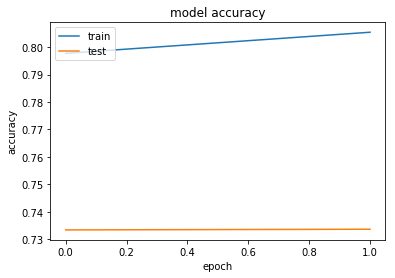

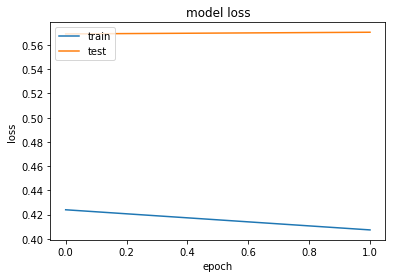

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [27]:
# Save the model
model.save("twitter_LSTM_alternate.h5")